# Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To handle track DataFrames
import pandas as pd
# For working with x-arrays
import xarray as xr
# To import images
from skimage import io 
from skimage.io import imread
# For TrackPy
import trackpy as tp
# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter1d
import seaborn as sns; sns.set()  
# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths
# For reloading a library when testing
# For deleting/reloading modules in another file for code testing
import sys
# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../croparray")
import crop_array_tools as ca
os.chdir(cwd)
# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 
plt.style.use('dark_background')


In [2]:
# parameters
particle_diameter= 7 #(3, 7, 7)   # Spot diameter :  z,y,x size of the spot      
tracking_channel = 0          # Channel  used for tracking
min_trajectory_length = 5    # Minimal number of frames to be consider as a trajectory

# selecting time and z for visualization
selected_time = 4 
selected_z = 3 

# Visualization. Static image taking a given time point. Plotting the maximum projection in Z for a given channel.
selected_channel = 0
drop_size = 3

# Video directory
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'  

In [3]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)

(1, 33, 7, 472, 312, 3)

In [ ]:
video2D = np.max(video[0,:,:,:,:,tracking_channel] ,axis=1)
video2D.shape

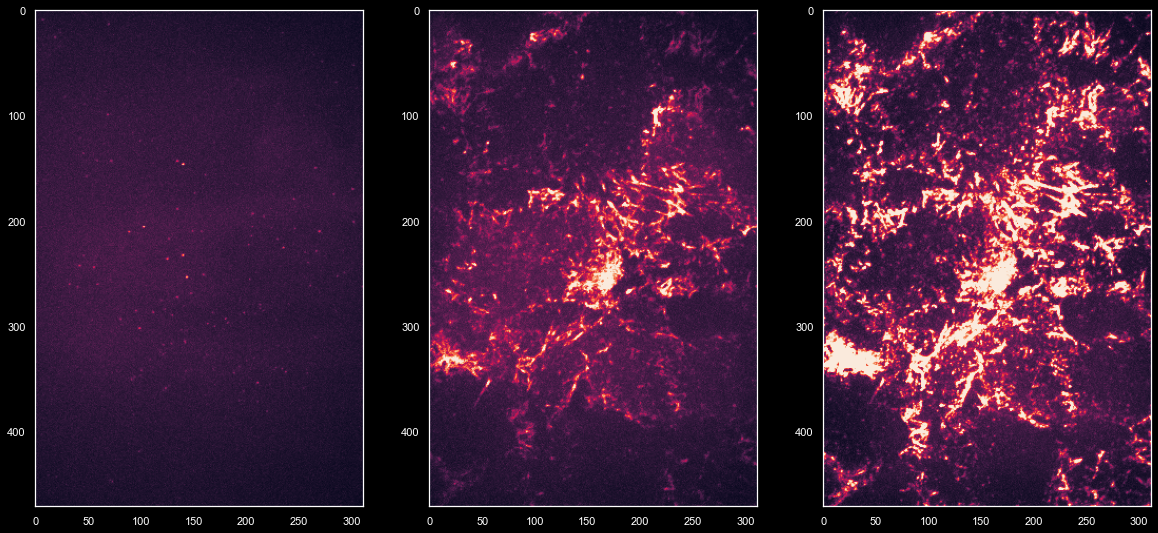

In [5]:
# Just examining one of the images
num_channels = 3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(20,10))
for i in range(0,num_channels):
    ax[i].imshow(np.max(video[0,0,:,:,:,i] ,axis=0) )
    ax[i].grid(False)

# Tracking with trackpy

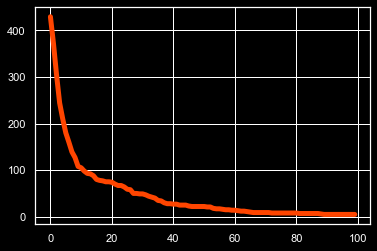

In [6]:
# Detecting particles for each frame
num_spots = []
num_iterations = 100
tested_intensities = np.round(np.linspace(40, np.amax(video2D), num_iterations ),0)
for i, int_tested in enumerate (tested_intensities):
    try:
        f = tp.locate(video2D[0,:,:], diameter=particle_diameter, minmass = int_tested )
        num_spots.append(len(f))
    except:
        num_spots.append(0)
num_spots =np.array(num_spots)        
plt.plot(num_spots, linewidth=5, color='orangered')

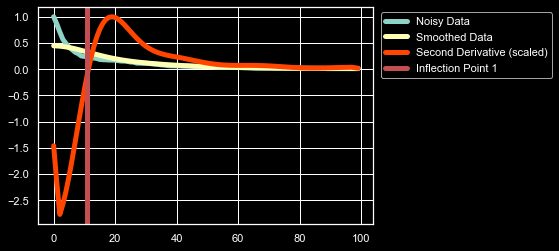

In [7]:
# https://stackoverflow.com/a/62538912/14672920
# Optimization process for selecting intensity
raw = num_spots/ np.max(num_spots)
# smooth
smooth = gaussian_filter1d(raw, 10)
# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))
# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]
# plot results
plt.plot(raw, label='Noisy Data',linewidth=5)
plt.plot(smooth, label='Smoothed Data',linewidth=5)
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)',color='orangered',linewidth=5)
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='r', label=f'Inflection Point {i}',linewidth=5)
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [9]:
selected_minmass = np.round(tested_intensities [infls[0]],0)
selected_minmass

64.0

In [10]:
# Batch process
f = tp.batch(video2D, diameter=particle_diameter,minmass=selected_minmass)

Frame 32: 92 features


In [11]:
# Linking trajectories
linked = tp.link_df(f, 10)
linked

Frame 32: 92 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,9.553957,6.896882,114.610822,1.398012,0.200465,16.215920,1102.0,-1.504064,0,0
72,293.846154,80.516765,139.346971,1.409324,0.179417,18.414688,1741.0,0.172692,0,1
71,290.094660,129.419903,113.236592,1.441412,0.286841,16.490766,1531.0,0.272544,0,2
69,287.875410,168.180328,83.828059,1.294376,0.237434,13.467459,1382.0,0.462139,0,3
68,287.466071,111.612500,153.913814,1.412950,0.172537,21.163149,1665.0,0.199089,0,4
...,...,...,...,...,...,...,...,...,...,...
3053,203.391429,248.937143,73.805477,1.557470,0.149983,9.278403,1401.0,0.417384,32,629
3052,201.891813,206.216374,72.118495,1.648143,0.383278,8.434912,1485.0,0.314289,32,540
3051,188.528926,133.407713,76.546824,1.479893,0.176212,10.332767,1568.0,0.252631,32,630
3060,210.573022,268.716024,207.920573,1.364948,0.231222,30.154809,1628.0,0.221253,32,84


In [12]:
# Filtering with minimum length
filtered_df = tp.filter_stubs(linked, min_trajectory_length)

In [13]:
# Renaming columns names
filtered_df['z']= 0  
filtered_df.rename(columns={'x': 'xc','y': 'yc', 'z': 'zc', 'frame': 'f','particle':'id','mass':'MEAN_INTENSITY'}, inplace=True, errors='raise')
# Chaning data type
spots = filtered_df.astype({'zc': int,'yc': int,'xc': int,'f': int,'id': int,'MEAN_INTENSITY': int})
spots['fov']= 0  
# Selecting some columns
spots=spots[['fov','id','f','zc','yc','xc','MEAN_INTENSITY']]

In [14]:
# From trackpy ids are not in order nor consecutive. This code replaces these values and make them ordered consecutive numbers.
unique_spots_id = spots.id.unique() # unique spots ids
# Replacing spots with id number.
for i,id_spot in enumerate(unique_spots_id):
    spots.loc[spots.id == id_spot,'id']=- i # To avoid replacing and mixing different numbers. I am making the new id a negative number.
spots['id'] = spots['id'].abs() # now getting the absolute value.
print('Detected trajectories: ',np.max(spots.id)+1 )
n_particles = spots['id'].nunique()
spots

Detected trajectories:  145


,fov,id,f,zc,yc,xc,MEAN_INTENSITY
frame,,,,,,,
0,0,0,0,0,9,6,114
0,0,1,0,0,293,80,139
0,0,2,0,0,290,129,113
0,0,3,0,0,287,111,153
0,0,4,0,0,286,95,130
...,...,...,...,...,...,...,...
32,0,57,32,0,204,98,235
32,0,141,32,0,204,300,97
32,0,65,32,0,203,237,124


# Plotting trajectories

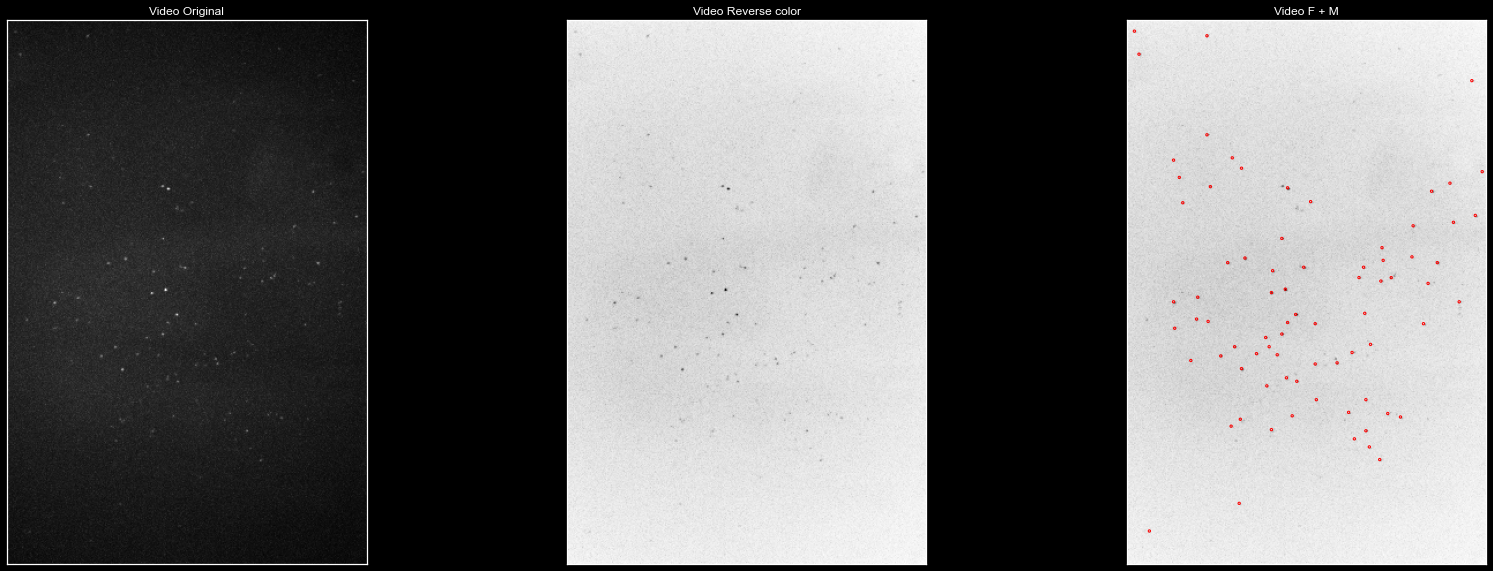

In [15]:
NUM_ROWS = 1
NUM_COLUMNS = 3
index_video = 0
title_str = 'Video'
individual_figure_size = 10
gs = gridspec.GridSpec(NUM_ROWS, NUM_COLUMNS)
gs.update(wspace = 0.01, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*NUM_COLUMNS, individual_figure_size*NUM_ROWS))

# Figure with raw video
ax = fig.add_subplot(gs[index_video])
img_projection=np.max(video[0,selected_time,:,:,:,selected_channel] ,axis=0)
ax.imshow(img_projection,cmap='gray') 
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' Original')
# Figure with filtered video
ax = fig.add_subplot(gs[index_video+1])
ax.imshow(img_projection,cmap='gray_r') 
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' Reverse color' )
# Figure with filtered video and marking the spots
ax = fig.add_subplot(gs[index_video+2])
ax.imshow(img_projection,cmap='gray_r') 
# Plots the detected spots.
for k in range (0, n_particles):
    frames_part = spots.loc[spots['id'] == spots['id'].unique()[k]].f.values
    if selected_time in frames_part: # plotting the circles for each detected particle at a given time point
        index_val = np.where(frames_part == selected_time)
        x_pos = int(spots.loc[spots['id'] == spots['id'].unique()[k]].xc.values[index_val])
        y_pos = int(spots.loc[spots['id'] == spots['id'].unique()[k]].yc.values[index_val])
        circle = plt.Circle((x_pos, y_pos), drop_size//2, color = 'red', fill = False)
        ax.add_artist(circle)
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' F + M' ) 
plt.show()

# Creatng croparray

In [16]:
my_ca = ca.create_crop_array(video,spots,xy_pad=5)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  80
Shape of numpy array to hold all crop intensity data:  (1, 80, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 80, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 80, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 80, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
  * t               (t) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int64 0 1 2 3 4 5 6
  * y               (y) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int64 11 13 12 16 17 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int64 12 12 12 105 105 105 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 15 15 15 308 308 308 ... 0 0 0 0 0 0
    dx              int64 1
    dy              int64 1
    dz              int64 1
    dt              int64 1
    id              (fov, n, t) float64 0.0 31.0 3.0 6.0 ... 0.0 0.0 0.0 0.0
    zc              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 114.0 234.0 154.0 88.0 ... 0.0 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

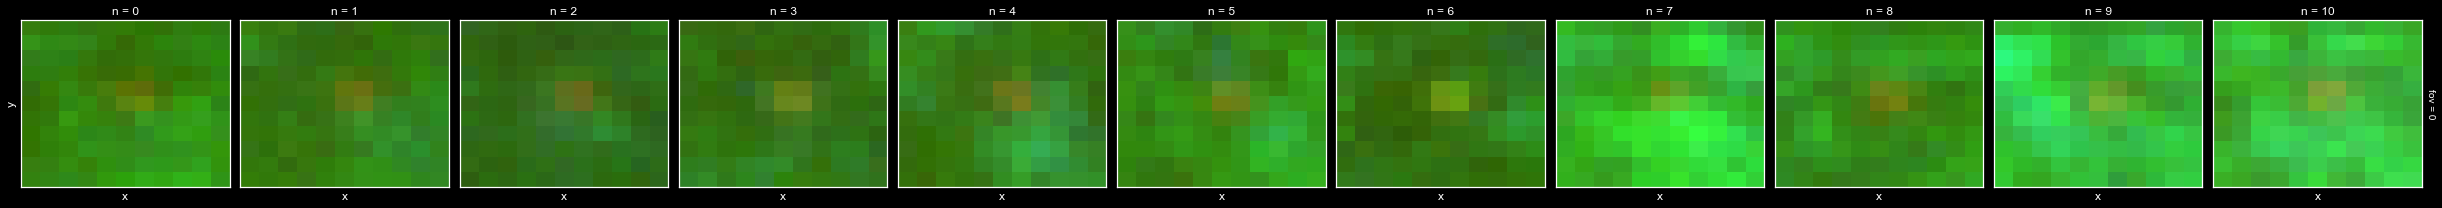

In [17]:
# Check the first 10 spots (max-z projected) of each fov to make sure things are centered. 
# Choosing ch = 1, 2 (translation), and 3 for rgb mapping
my_ca.int.sel(ch=[0,1,2],n=slice(0,10)).mean(dim=['t']).max('z').plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[])

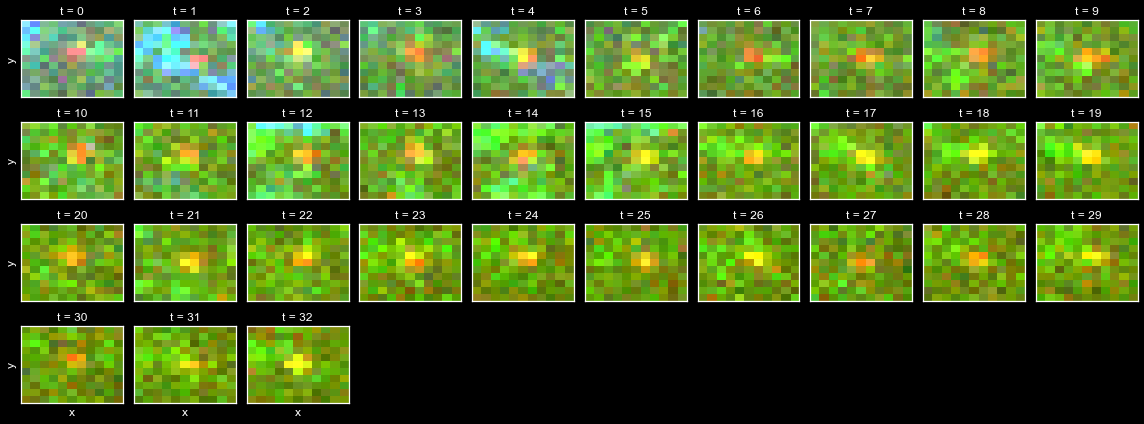

In [31]:
# Plot one of the crops over time to test
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
best_z.where(my_ca.id==1).mean('n').sel(fov=0).plot.imshow(col='t',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

# Sorting crop ids by average translation signal intensity through time

---

In [19]:
# Create best-z projection (if not already)
# Make a background subtracted x-array for plotting on same scale
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
best_z_bg = best_z -donut_sig

# Now sort based on signal average over time with disk-donut intensity
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
signal = disk_sig - donut_sig
my_ca['signal'] = signal
my_ca['signal'].attrs['notes']='Disk donut on best_z_bg w/ ref_ch=0, disk_r=4, roll_n=3, donut_r = 5-6'

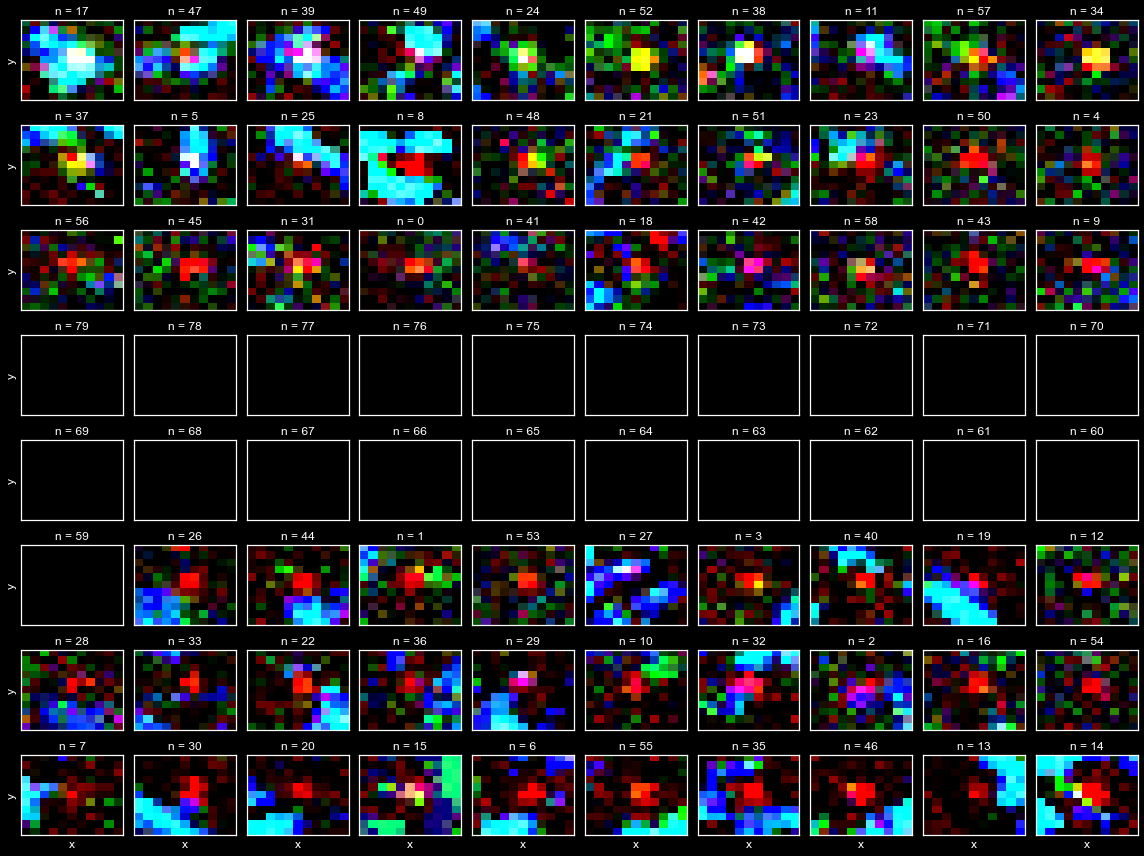

In [20]:
# Visualize the sorted spots t = 0
ca_sort = best_z_bg.sel(t=0).sortby(my_ca.signal.sel(t=0,ch=1,fov=0),ascending=False)
ca_sort.sel(fov=0).plot.imshow(col='n',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

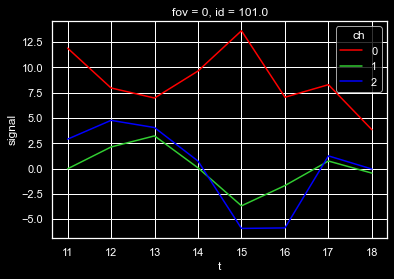

In [21]:
# If ids correspond to tracks, we can also visualize tracks through time  
my_id = np.unique(my_ca.id) # Find all unique ids
# We create a dataset with 'id' as a coordinate in this case
track_sig = xr.concat([my_ca.signal.where(my_ca.id == i).mean(['n']) for i in my_id],dim=pd.Index(my_id, name='id')).to_dataset()
# This allows us to focus on specific tracks in plots:
sns.set_palette(['red','limegreen','blue'])
track_sig.sel(id=101,fov=0).signal.plot.line(x='t',hue='ch')

In [32]:
# Now we sort the trck ids by the mean intensity of each track through time 
# We can look for tracks with bright translation signals, but dim mature protein signals 
# For this, we sort by translation signal - mature protein signal (or could do any variant)
sorted = track_sig.sortby(track_sig.signal.sel(fov=0,ch=1).mean('t'),ascending=False)
sorted_ids = sorted.id.values.astype(int)
print(sorted_ids.shape)
print(sorted_ids)


(145,)
[ 91   7 114  49 118 133 138  47   9  81 124   5  48  34  83  39  70 111
  46  29  86  67   3 134  37  23  10  52  13 108  94   1  21  73 136 144
  59  61 107  38  95  41  64 132  58  87  44  60  32  31  57  82 113 126
  15  76  12  65  56  75  11 142  77  71  62 119 104 128 103  50  42  36
  69 127 101   0 137 129 140 105  72  43 125  89 120 100 112  51  74  26
  17  27  80  22  45 106  63  16  33  96  54  85  30 131   2  28  24 141
   4  84  78 121  98  99  35 116  92 123  40  19  66  25  79   6  88 143
  97 109  68 110  53  20   8  90 122  14 115 102  18 135  93 117  55 130
 139]


In [23]:
# To visualize the time-averaged tracks all sorted, we create a crop array and plot it 
sorted_xr = xr.concat([best_z_bg.where(my_ca.id==i, drop=True).mean(dim=['n']) for i in sorted_ids], dim=pd.Index(sorted_ids, name='id'))

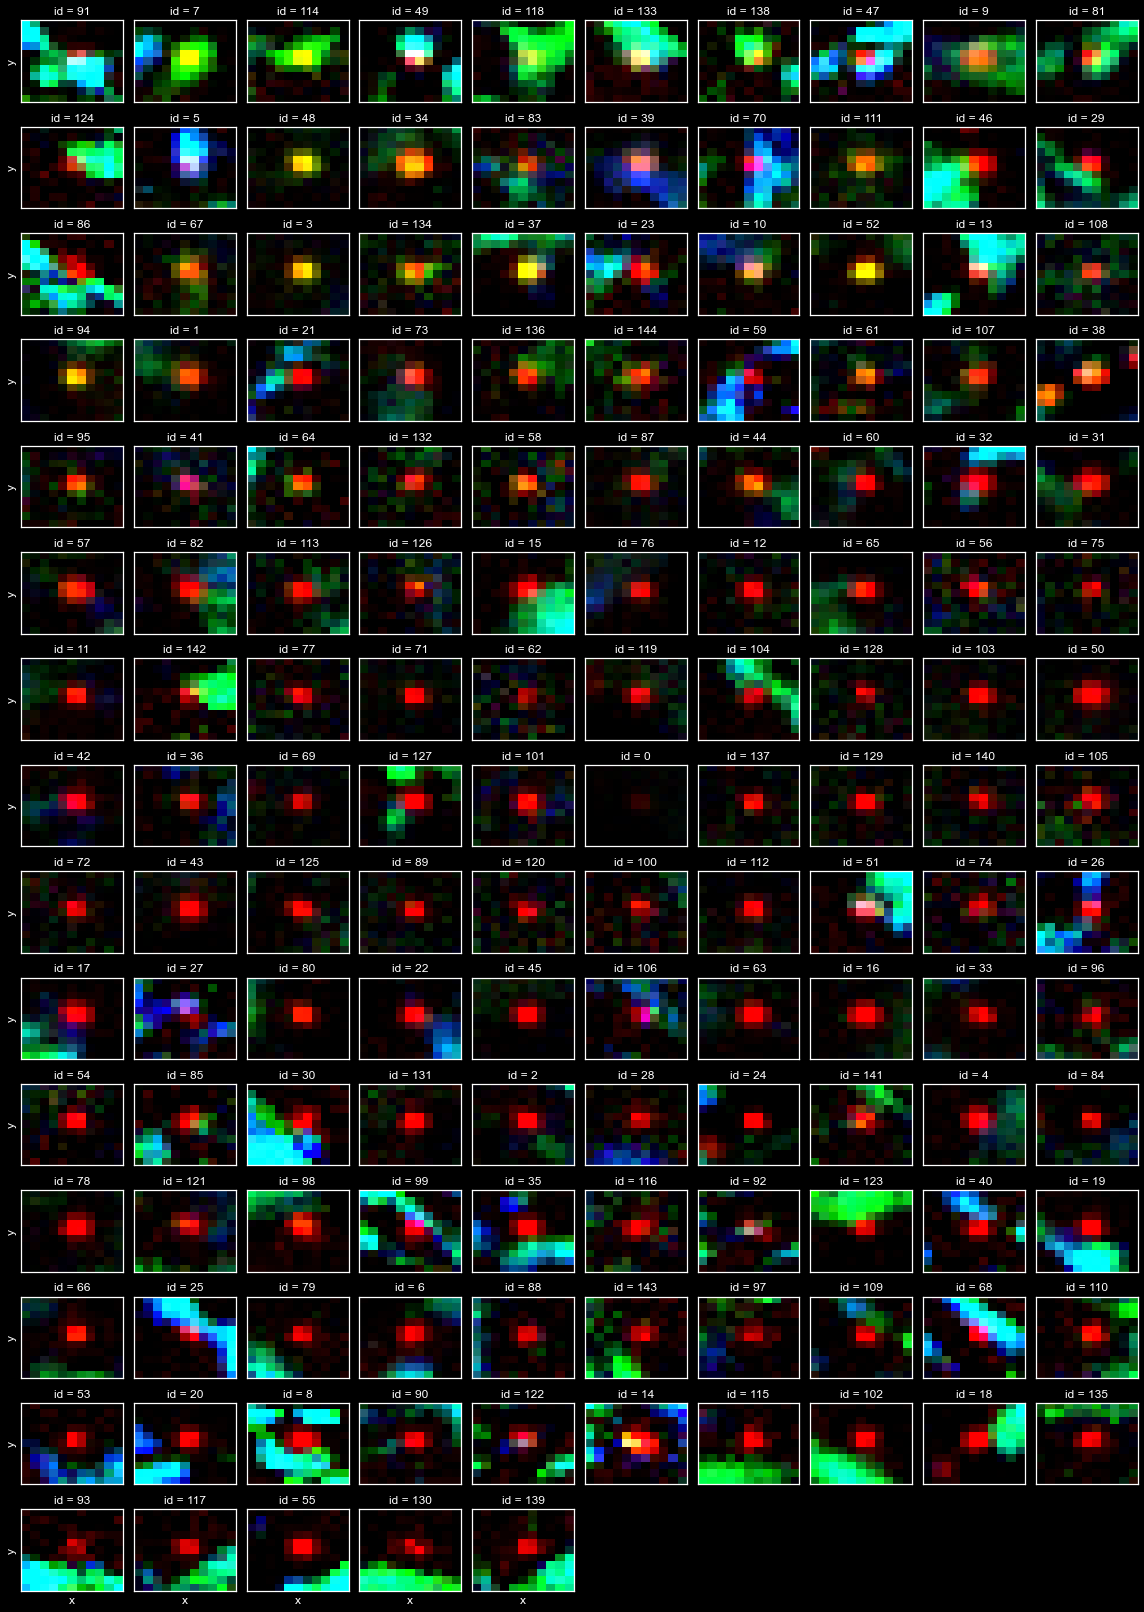

In [24]:
sorted_xr.sel(fov=0).mean('t').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

In [25]:
crop_array = ca.montage(my_ca, row = 't', col = 'n').int.sel(ch=0)
crop_array.shape

# Plotting a croparray

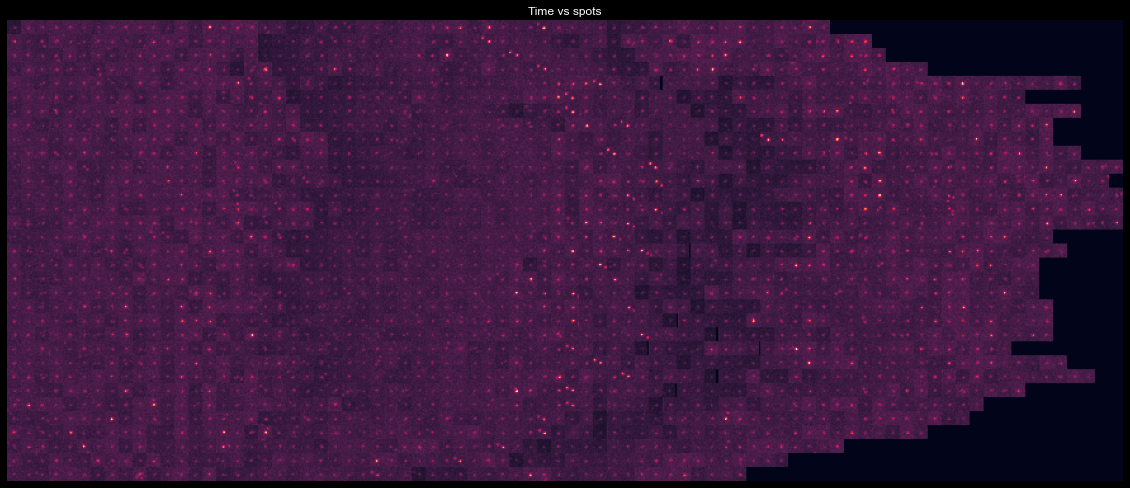

In [27]:
# Plotting
f = plt.figure(figsize=(20,15))
ax = plt.gca()
plt.imshow(np.max(crop_array[0,:,:,:],axis=0))
plt.title("Time vs spots")
plt.grid(False)
plt.axis('off')
plt.show()